In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tomotok
import calcam
import cv2 #opencv

from tomotok.core.derivative import compute_iso_dmats, compute_aniso_dmats
from tomotok.core.phantoms import gauss_iso, iso_psi, gauss
from tomotok.core.geometry import sparse_line_3d, RegularGrid, generate_los
from tomotok.core.inversions import CholmodMfr, Mfr, SvdFastAlgebraic, Fixt, GevFastAlgebraic
from scipy.ndimage import gaussian_filter

from IPython.display import Image

In [2]:
#calirad = calcam.Calibration('calibration_r11_s.ccc') #loading Calcam calibration file for radial camera ip:...11
#caliver = calcam.Calibration('calibration_v10_s.ccc') #loading Calcam calibration file for vertical camera ip:...10
caliradnew = calcam.Calibration('13rad.ccc')
calivernew = calcam.Calibration('12ver.ccc')

In [3]:
#Reconstruction grid generation

gridrn=50 #number of grid voxels/nodes in r direction
gridzn=50 #number of grid voxels/nodes in z direction

plasmaradius = 0.085 #radius of plasma (and of the reconstruction domain), 0.085 for limiter
chamberradius = 0.1 #chamber radius
plasmacentre = 0.40 #minor tokamak radius
padding = 0.015 #

gridrmin = plasmacentre - plasmaradius - padding
gridrmax = plasmacentre + plasmaradius + padding
gridzmin = - plasmaradius - padding
gridzmax = plasmaradius + padding

#grid generation (# of r nodes, # of z nodes, r span, z span)
grid = RegularGrid(gridrn, gridzn, (gridrmin, gridrmax), (gridzmin, gridzmax))
nx = grid.nr
ny = grid.nz
#wm = np.ones((ny, nx))
#wm = wm.flatten()

In [4]:
#Limiter and chamber radii definitions


t = np.linspace(0,2*np.pi,100) #t is just a parameter for the curves/circles

#limiter curve definition
r = plasmacentre + plasmaradius*np.sin(t)
z = plasmaradius*np.cos(t)

#chamber curve definition
R = plasmacentre + chamberradius*np.sin(t)
Z = chamberradius*np.cos(t)

#weight matrix - all voxels/nodes outside of limiter are discarded 
#bdm = grid.is_inside(r, z)
bdm = grid.is_inside(R, Z)

#smooth_boundary = 0.1 #weight of pixels outside boundary
#nx = grid.nr
#ny = grid.nz
#wm = np.ones((ny, nx))
#wm = gaussian_filter(wm, sigma=3, mode='nearest')
#wm = np.where(bdm, wm, smooth_boundary)

In [5]:
#Rotation and translation matrices for geometry calibration
#Transformation from 3D scan coordinate system to standard tokamak coordinate system
#Color cameras 12ver and 13rad
Rver = np.array([
        [-0.07368548,  0.70552056, -0.70480682],
        [-0.94196714, -0.28186259, -0.18360485],
        [-0.32812453,  0.65004673,  0.685347  ]])

Tver = 0.001*np.array([ 296.06325909, -326.27299764, -232.22270139])

Rrad = np.array([
        [-0.76218968, -0.60296435, -0.23470144],
        [-0.01174398,  0.37567001, -0.92658995],
        [ 0.64686443, -0.70361531, -0.29339289]])

Trad = 0.001*np.array([133.09005651, 226.58939127, -48.28396016])

#B&W cameras 11 and 10 to be added on request (Jakub Chlum chlumja3@cvut.cz)

In [6]:
rowrad = 511 #which radial camera detector row to use for reconstruction
rowver = 511 #which vertical camera detector row to use for reconstruction

#getting lines of sight directions for a row of camera detectors from Calcam calibration files
pxx = range(0,1280)
pxyrad = [rowrad]*1280
pxyver = [rowver]*1280
ogdirrad = caliradnew.get_los_direction(pxx,pxyrad) 
ogdirver = calivernew.get_los_direction(pxx,pxyver)

dirver = np.zeros((1280, 3))
dirrad = np.zeros((1280, 3))

#rotation of lines of sight directions based on camera positions and orientations
for i in range(np.shape(ogdirver)[0]):
    dirver[i] = np.dot(ogdirver[i],Rver)

for i in range(np.shape(ogdirrad)[0]):
    dirrad[i] = np.dot(ogdirrad[i],Rrad) 

dirrad = dirrad.reshape(-1, 3)
dirver = dirver.reshape(-1, 3)

#relative camera positions
posver = calivernew.get_pupilpos()
pupilver = np.dot(posver,Rver) + Tver
posrad = caliradnew.get_pupilpos()
pupilrad = np.dot(posrad,Rrad) + Trad

#Discarding obstucted detectors
leftstoprad = 0 #leftmost R camera detector to be used (useful if cameras' view is obstructed on edges, 0 if all detectors see the plasma)
rightstoprad = 1280 #rightmost R camera detector to be used (1280 if all)
totalspanrad = rightstoprad - leftstoprad

leftstopver = 0 #leftmost V camera detector to be used (useful if cameras' view is obstructed on edges, 0 if all detectors see the plasma)
rightstopver = 1280 #rightmost V camera  detector to be used (1280 if all)
totalspanver = rightstopver - leftstopver

#Lines of sight chords generation, based on Tomotok's generators.py - calcam_sparse_line_3d
xchordsrad = np.ones((totalspanrad, 2)) * pupilrad[0]
xchordsrad[:, 1] += dirrad[leftstoprad:rightstoprad, 0]
ychordsrad = np.ones((totalspanrad, 2)) * pupilrad[1]
ychordsrad[:, 1] += dirrad[leftstoprad:rightstoprad, 1]
zchordsrad = np.ones((totalspanrad, 2)) * pupilrad[2]
zchordsrad[:, 1] += dirrad[leftstoprad:rightstoprad, 2]

xchordsver = np.ones((totalspanver, 2)) * pupilver[0]
xchordsver[:, 1] += dirver[leftstopver:rightstopver, 0]
ychordsver = np.ones((totalspanver, 2)) * pupilver[1]
ychordsver[:, 1] += dirver[leftstopver:rightstopver, 1]
zchordsver = np.ones((totalspanver, 2)) * pupilver[2]
zchordsver[:, 1] += dirver[leftstopver:rightstopver, 2]
xchords = []
ychords = []
zchords = []

#Joining radial and vertical chords
xchordsr = np.array(xchordsrad)
xchordsv = np.array(xchordsver)
xchords = np.concatenate((xchordsv, xchordsr),axis=0)

ychordsr = np.array(ychordsrad)
ychordsv = np.array(ychordsver)
ychords = np.concatenate((ychordsv, ychordsr),axis=0)

zchordsr = np.array(zchordsrad)
zchordsv = np.array(zchordsver)
zchords = np.concatenate((zchordsv, zchordsr),axis=0)

#Generating geometry matrix 
gmat = sparse_line_3d(xchords, zchords, grid, ychords, 0.0001 , rmin=0.3)


Gmat generation time 2.01s average time per chord 1ms


In [7]:
#Psi generation
nx = grid.nr
ny = grid.nz
span = plasmaradius
offsetx = 0.01 #offset of centre in x direction 
offsety = 0 #offset of centre in y direction 
x = np.linspace(-span, span, nx)
y = np.linspace(-span, span, ny)
mx, my = np.meshgrid(x, y)

#Simplest possible Psi - concentric circles
#ipsi = np.sqrt((mx -offsetx)*( mx-offsetx) + (my-offsety) *(my-offsety))

#Simplest ~physical Psi - Solovyev solution of G-S equation
R0 = 0.4
a = 0.085
eps = a/R0
tau = 1
sigma = 1
ipsi = ( ((mx)/a) - (eps/2)*(1-((mx)/a)**2))**2 + (1-eps**2/4)*(my/a)**2


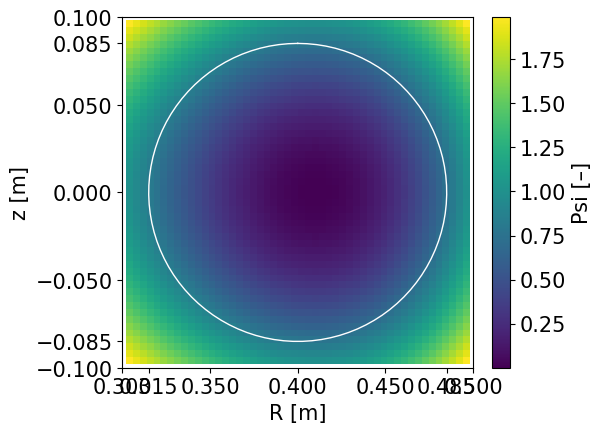

In [8]:
plt.rcParams['font.size'] = '15'


f, a = plt.subplots(figsize=(5,5),dpi=100)
# img = a.imshow(res.reshape(grid.shape), origin='lower', extent=grid.extent)  # nodes must be squares
img = a.pcolorfast(grid.r_center, grid.z_center, ipsi)
plt.plot(r,z, 'w', lw=1)
a.set_aspect(1)
a.set_xlabel('R [m]')
a.set_ylabel('z [m]')

plt.title('')

plt.xticks([gridrmin,gridrmax,0.4,0.315,0.485,0.45,0.35])
plt.yticks([gridzmin,gridzmax,0.,-0.085,0.085,0.05,-0.05])
#plt.xticks(rotation = 90)

cbar = f.colorbar(img, ax=a, fraction=0.0452, pad=0.05)
cbar.ax.set_ylabel('Psi [–]')

imagename='mag_flux.png'
plt.savefig(imagename,bbox_inches="tight")

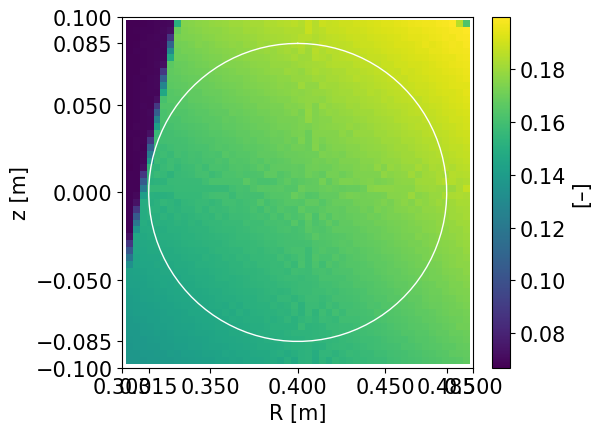

In [9]:
plt.rcParams['font.size'] = '15'

f, a = plt.subplots(figsize=(5,5),dpi=100)
# img = a.imshow(res.reshape(grid.shape), origin='lower', extent=grid.extent)  # nodes must be squares
img = a.pcolorfast(grid.r_center, grid.z_center, gmat.toarray().sum(0).reshape(grid.shape))
plt.plot(r,z, 'w', lw=1)
a.set_aspect(1)
a.set_xlabel('R [m]')
a.set_ylabel('z [m]')

plt.title('')

plt.xticks([gridrmin,gridrmax,0.4,0.315,0.485,0.45,0.35])
plt.yticks([gridzmin,gridzmax,0.,-0.085,0.085,0.05,-0.05])
#plt.xticks(rotation = 90)

cbar = f.colorbar(img, ax=a, fraction=0.0452, pad=0.05)
cbar.ax.set_ylabel('[–]')

imagename='geometric_matrix.png'
plt.savefig(imagename,bbox_inches="tight")

In [10]:
def datafromimage(framenumber):
    #Obtaining data from single frame from both videos 
    
    #Camera data (example for R camera: Data.avi in http://golem.fjfi.cvut.cz/shots/42102/Diagnostics/FastCameras/Default/Camera_Radial/)
    capver = cv2.VideoCapture(r'ver42102.avi') #vertical camera data
    caprad = cv2.VideoCapture(r'rad42102.avi') #radial camera data
    
    capver.set(1,framenumber);
    caprad.set(1,framenumber);
    retver, framever = capver.read() 
    retrad, framerad = caprad.read() 
    
    #Saving frames
    namever = 'frames/vframe00' + str(framenumber) + '.png'
    cv2.imwrite(namever, framever) 
    namerad = 'frames/rframe00' + str(framenumber) + '.png'
    cv2.imwrite(namerad, framerad) 

    channel = 0 #color channel to be used 012 BGR
    ogimagerad = cv2.imread(namerad,cv2.IMREAD_UNCHANGED )[:,:,channel] #loading radial image 
    ogimagever = cv2.imread(namever,cv2.IMREAD_UNCHANGED )[:,:,channel] #loading vertical image

    length_ver = int(capver. get(cv2. CAP_PROP_FRAME_COUNT))
    length_rad = int(caprad. get(cv2. CAP_PROP_FRAME_COUNT))

    fullheight = 1024 #height of full camera picture in pixels
    fullwidth = 1280 #width of full camera picture in pixels
    imgheight = np.shape(ogimagerad)[0] #height of loaded image, 
    imgheighthalf = int((fullheight-imgheight)/2) #where to insert loaded image into 1024 by 1280 array for easier handling of distortion

    
    imagerad = np.zeros((fullheight-imgheight, fullwidth))
    imagever = np.zeros((fullheight-imgheight, fullwidth))
    imagerad = np.insert(imagerad, imgheighthalf, ogimagerad, axis=0)
    imagever = np.insert(imagever, imgheighthalf, ogimagever, axis=0)
    
    #imagever = np.flip(imagever)
    #imagerad = np.flip(imagerad)

    imagerad = imagerad[rowrad:rowrad+1,leftstoprad:rightstoprad] #taking signal from only one row of camera detectors
    imagever = imagever[rowver:rowver+1,leftstopver:rightstopver]
    imagever = np.squeeze(imagever,axis=0)
    imagerad = np.squeeze(imagerad,axis=0)
    
    
    sig = np.concatenate((imagever, imagerad), axis=0)
    
    capver.release()
    caprad.release()
    return sig

In [14]:
def datasolve(framenumber, sig, grid, magflux, mask):
    #Tomographic reconstruction using MFR of single frame data, saves result in /res/---.npy
    #framenumber 
    #sig - camera signal to be reconstructed, most likely from datafromimage()
    #grid - reconstruction grid
    #magflux - magnetic flux surfaces
    #mask - mask for the reconstruction grid, reconstruction only within limiter right now 
    
    data = sig.reshape(1, -1)  # data should have shape (#timeslices, #channels/pixels)
    try: 
        solver = CholmodMfr()  # requires scikit.sparse
    except ImportError:
        solver = Mfr()  # slowlier version based on scipy.sparse

    
    
    errors = .01*data + 5 #error estimation. This works, but should be improved and studied further
    #errors = 20

    # dmats = compute_iso_dmats(grid)
    dmats = compute_aniso_dmats(grid, magflux=ipsi, mask=bdm) #derivative matrix with mask
    gmat_sel = gmat[:, bdm.flatten()] #geometric matrix with mask

    #actual tomographic reconstruction
    #res, chi = solver(data, gmat_sel, dmats, errors,aniso=3)


    solver = Fixt() 
    res, chi = solver(data, gmat_sel, dmats, errors,aniso=3,parameters = [1,1,1])

    #solver = SvdFastAlgebraic()
    #res, chi = solver(data, gmat_sel, dmats, errors)

    #reshaping result to original grid shape
    res2 = np.zeros((1, grid.shape[0]*grid.shape[1]))
    res2[0, bdm.flatten()] = res
    res2 = res2.reshape(1, *grid.shape)
    np.save('res/res_'+ str(framenumber), res2, allow_pickle=True, fix_imports=True)
    return res2


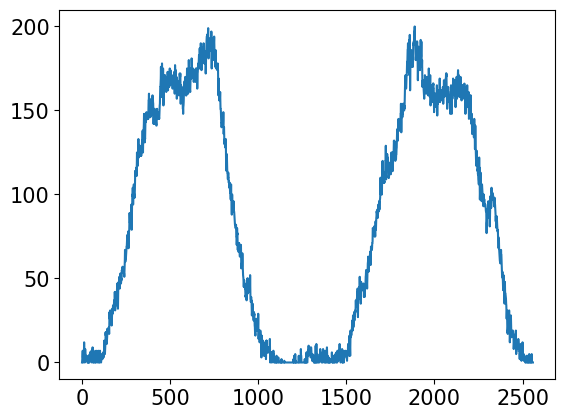

In [15]:
#Frame numbers to reconstruct
minrange = 156 #starting frame number
maxrange = minrange+1 #ending frame number

minrange = 156 #starting frame number
maxrange = 17*30 +23 #ending frame number

minrange = 260 #starting frame number
maxrange = minrange+1 #ending frame number

data = datafromimage(minrange)
plt.plot(data)

In [16]:
#Tomographic reconstructions of all frames selected
maxres = 0
for i in range(minrange,maxrange):
    data = datafromimage(i)
    res = datasolve(i, data, grid, ipsi, bdm)
        
    #Magflux based on centre of gravity of previous frame, should be improved
    #offsetx = np.sum(res * mx)/np.sum(res)
    #offsety = np.sum(res * my)/np.sum(res)
    #ipsi = np.sqrt((mx -offsetx)*( mx-offsetx) + (my-offsety) *(my-offsety))


last chi^2 = 1.6525, time: 1.91 s


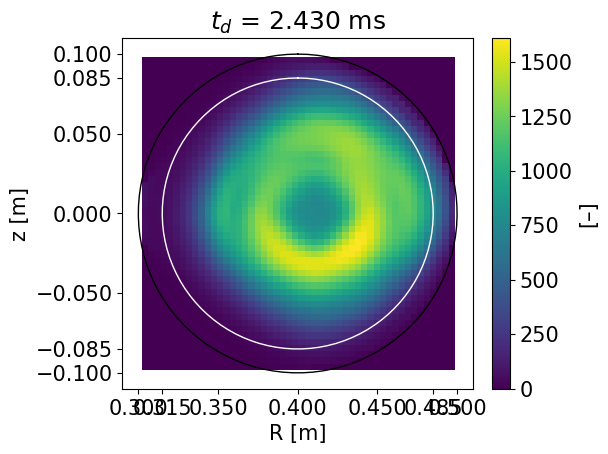

In [17]:
#Plot all reconstructions

#Finding maximum in all results - to have a stationary colorbar
maxres= 0
for i in range(minrange,maxrange):
    res2 = np.load('res/res_'+ str(i)+'.npy', mmap_mode=None, allow_pickle=True, fix_imports=True)
    maxres = max(maxres, np.max(res2))
    
    
    
plt.rcParams['font.size'] = '15'

for i in range(minrange,maxrange):
    f, a = plt.subplots(figsize=(5,5),dpi=100)
    img = a.pcolorfast(grid.r_center, grid.z_center, np.load('res/res_'+ str(i)+'.npy', mmap_mode=None, allow_pickle=True, fix_imports=True)[0], vmax=maxres)
    plt.plot(r,z, 'w', lw=1)
    plt.plot(R,Z, 'k', lw=1)
    a.set_aspect(1)
    a.set_xlabel('R [m]')
    a.set_ylabel('z [m]')
    
    framerate = 40000
    starttime = 4.07 #ms
    time = i/framerate * 1000-starttime
    plt.title('$t_d$ = '+"{:.3f}".format(time)+' ms')

    plt.xticks([gridrmin,gridrmax,0.4,0.315,0.485,0.45,0.35])
    plt.yticks([gridzmin,gridzmax,0.,-0.085,0.085,0.05,-0.05])
    #plt.xticks(rotation = 90)

    cbar = f.colorbar(img, ax=a, fraction=0.0452, pad=0.05)
    cbar.ax.set_ylabel('[–]')

    imagename='res/res_'+str(i)+'.png'
    plt.savefig(imagename,bbox_inches="tight",transparent=True)

In [18]:

img_array = []
for i in range(200,maxrange):
    img = cv2.imread('res/res_'+str(i)+'.png')
    img_array.append(img)

size = (np.shape(img)[1],np.shape(img)[0])

out = cv2.VideoWriter('20frames3.avi',cv2.VideoWriter_fourcc(*'DIVX'), 10, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

In [19]:
minrange = 0
maxrange = 1000

for i in range(minrange,maxrange):
    plt.clf()
    ax = plt.gca()
    ax.set_ylim([0, 256])
    data = datafromimage(i)
    plt.plot(data)
    imagename='data/data_'+str(i)+'.png'
    plt.savefig(imagename,bbox_inches="tight",transparent=True)

In [ ]:
img_array = []
for i in range(minrange,maxrange):
    img = cv2.imread('data/data_'+str(i)+'.png')
    img_array.append(img)

size = (np.shape(img)[1],np.shape(img)[0])

out = cv2.VideoWriter('dataframes.avi',cv2.VideoWriter_fourcc(*'DIVX'), 10, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

: 